In [1]:
import geopandas as gpd
import pandas as pd

import os
repo_dir = os.environ.get("REPO_DIR")
data_dir = os.path.join(repo_dir, "data/")
code_dir = os.path.join(repo_dir, "code/")
os.chdir(code_dir)

import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
# import pickle
# import sklearn 
import sys
import pandas as pd
from importlib import reload
import sklearn.metrics

import geopandas as gpd

import warnings

from scipy.stats import spearmanr


from analysis.NL_feature_creation_and_other_NL_processing.nl_helpers import apply_polygon_mask_and_return_flat_array

from mosaiks.utils.io import weighted_groupby

/home/groups/smhsiang/venv/hdi/lib/python3.9/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
indonesia_dir = data_dir + "raw/indonesia_hdi/"

# Satellite-derived HDI for Mexican municipalities
#sat = pd.read_pickle(data_dir + "preds/hdi_preds_at_adm2.p") ## Full file is too large to GitHub repo
sat = pd.read_pickle(data_dir + "preds/hdi_preds_at_adm2_BRA_IDN_MEX.p").reset_index()
sat.rename(columns = {"adjusted_preds" : "adm2_pred","adm1_mean":"adm1_truth"},inplace=True)

sat = sat[sat["shapeGroup"] == "IDN"]

In [3]:
df = pd.read_excel(indonesia_dir  + "2019_hdi_by_gender_indonesia.xlsx",header=1).loc[1:578]
df["Male"] = pd.to_numeric(df["Male"], errors="coerce")
df["Female"] = pd.to_numeric(df["Female"], errors="coerce")

df["adm2_true"] = (df["Male"] + df["Female"])/200

In [4]:
df.columns = ["adm2_name"] + list(df.columns[1:])

In [5]:
print( (sat["shapeName"].isin(df["adm2_name"]).sum() / len(sat["shapeName"])).round(3), "% of ADM2 units are an exact text match")

0.977 % of ADM2 units are an exact text match


In [6]:
sat = sat.merge(df, how="left", left_on="shapeName", right_on="adm2_name")

Text(0.5, 1.0, 'ADM2 HDI Predicted')

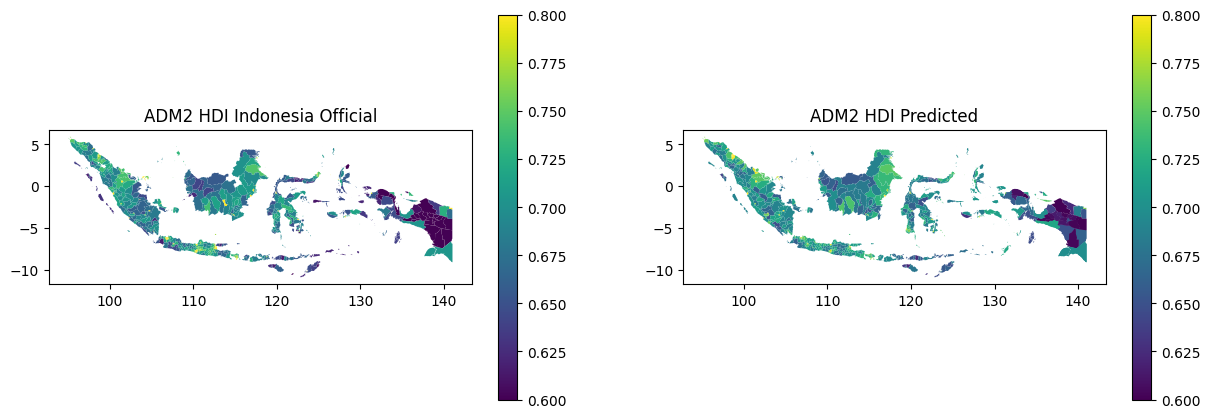

In [7]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

sat.plot(column="adm2_true", ax=ax[0], legend=True, vmin=.6, vmax=.80)
ax[0].set_title("ADM2 HDI Indonesia Official")

sat.plot(column="adm2_pred", ax=ax[1], legend=True, vmin=.6, vmax=.80)
ax[1].set_title("ADM2 HDI Predicted")

In [8]:
## Now compare perf

In [9]:
data = sat.copy()
data = data.rename(columns = {"adm2_true":"mhdi"}) # Rename so as to be consistent with the mexico stuff

In [10]:
null_count = data["adm2_pred"].isnull().sum() + data["mhdi"].isnull().sum()

print("We dont have preds for", null_count, "ADM2 observations. These will be dropped")

print("This is", round(null_count/len(data) * 100,2), "% of the data.")

data.dropna(subset = ["adm2_pred", "mhdi"], inplace=True)

We dont have preds for 38 ADM2 observations. These will be dropped
This is 7.0 % of the data.


In [11]:
data["within_adm0_true"] = data["mhdi"] - data["mhdi"].mean()
data["within_adm0_pred"] = data["adm2_pred"] - data["adm2_pred"].mean()

In [12]:
adm1_pred_means = data.groupby("GDL_ADM1")["adm2_pred"].mean().rename("adm1_pred_mean")
adm1_true_means = data.groupby("GDL_ADM1")["mhdi"].mean().rename("adm1_true_mean")

In [13]:
data = data.merge(adm1_pred_means, "left", left_on="GDL_ADM1", right_index=True)
data = data.merge(adm1_true_means, "left", left_on="GDL_ADM1", right_index=True)

data["within_adm1_pred"] = data["adm2_pred"] - data["adm1_pred_mean"]
data["within_adm1_true"] = data["mhdi"] - data["adm1_true_mean"]

In [14]:
np.corrcoef(data["within_adm1_true"],data["within_adm1_pred"])[0,1] ** 2

0.5330928066048816

In [15]:
data.to_pickle(data_dir+"/preds/indonesia_pred_and_observed.p")

holdout r2: 0.532
holdout Pearson R: 0.730




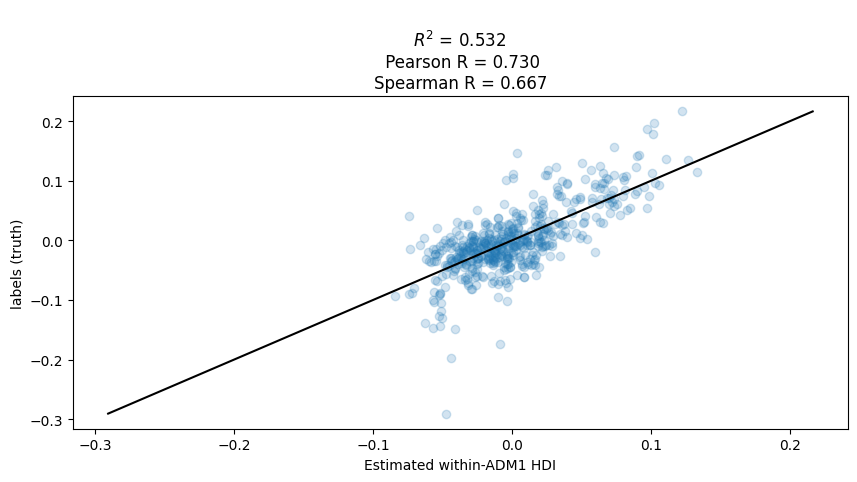

In [16]:
from analysis.prediction_utils import make_train_pred_scatterplot

make_train_pred_scatterplot("",data["within_adm1_true"],data["within_adm1_pred"], x_label="Estimated within-ADM1 HDI")

holdout r2: 0.591
holdout Pearson R: 0.789




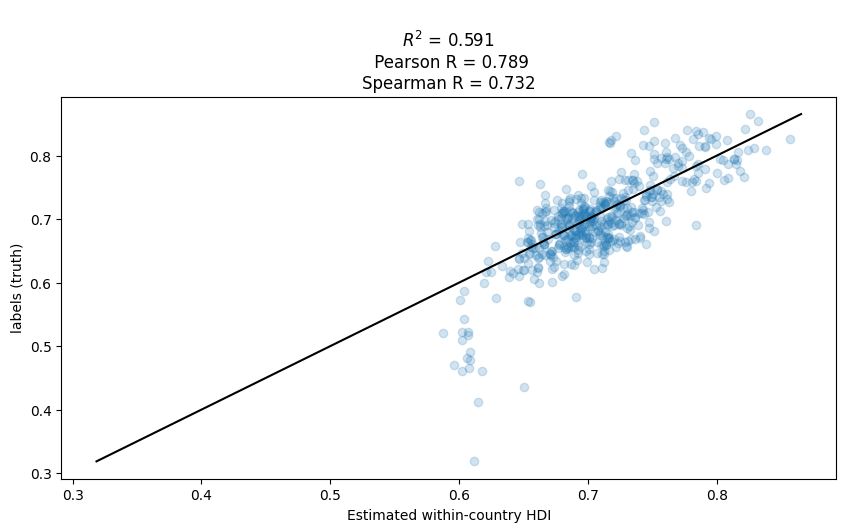

In [17]:
make_train_pred_scatterplot("",data["mhdi"],data["adm2_pred"], x_label="Estimated within-country HDI")

### Now we make the big table with results from all models

In [18]:
all_model_preds = pd.read_pickle(data_dir + "preds/hdi_preds_from_all_models_at_adm2.p").loc[data["shapeID"]]
all_model_preds = all_model_preds.merge(data.set_index("shapeID")[["GDL_ADM1","mhdi"]], "left", left_index=True, right_index=True)

def get_perf_metrics(col, df, truth_col="mhdi"):
    perf = {}
    
    within_adm0_true = df[truth_col] - df[truth_col].mean()
    within_adm0_pred = df[col] - df[col].mean()
    
    perf["within_adm0_pearson"] = np.corrcoef( within_adm0_true,within_adm0_pred )[0,1] **2
    perf["within_adm0_spearman"] = spearmanr(within_adm0_true,within_adm0_pred ).correlation
    perf["within_adm0_r2"]  = sklearn.metrics.r2_score(within_adm0_true,within_adm0_pred )
    
    grouped = all_model_preds.groupby("GDL_ADM1")[[col, truth_col]].mean().rename(columns = {col:"adm1_pred_grouped_mean", 
                                                                              truth_col:"adm1_truth_grouped_mean"})
    df = df.merge(grouped, "left", left_on="GDL_ADM1", right_index=True )
    
    within_adm1_true = df[truth_col] - df["adm1_truth_grouped_mean"]
    within_adm1_pred = df[col] - df["adm1_pred_grouped_mean"]
    
    perf["within_adm1_pearson"] = np.corrcoef( within_adm1_true,within_adm1_pred )[0,1] **2
    perf["within_adm1_spearman"] = spearmanr(within_adm1_true,within_adm1_pred ).correlation
    perf["within_adm1_r2"]  = sklearn.metrics.r2_score(within_adm1_true,within_adm1_pred )
    
    return perf
    
    
    
    
perf_dict = {}
for col in all_model_preds.columns[:-2]:
    perf_dict[col] = get_perf_metrics(col, all_model_preds)

In [19]:
perf_dict

{'rcf_and_nl_cc_preds': {'within_adm0_pearson': 0.49888100761245086,
  'within_adm0_spearman': 0.6671828676798525,
  'within_adm0_r2': 0.3747909125357829,
  'within_adm1_pearson': 0.5121069064940531,
  'within_adm1_spearman': 0.6561015107721954,
  'within_adm1_r2': 0.3729824320596584},
 'rcf_cc_preds': {'within_adm0_pearson': 0.39304564273692694,
  'within_adm0_spearman': 0.5684754969792766,
  'within_adm0_r2': 0.26356055028946745,
  'within_adm1_pearson': 0.36133493126461547,
  'within_adm1_spearman': 0.543122045123767,
  'within_adm1_r2': 0.13708792600040076},
 'nl_cc_preds': {'within_adm0_pearson': 0.520777978705976,
  'within_adm0_spearman': 0.7233344200888131,
  'within_adm0_r2': -0.18862998040310996,
  'within_adm1_pearson': 0.5383296065468497,
  'within_adm1_spearman': 0.6965470156459829,
  'within_adm1_r2': -0.023543529602870095},
 'adm0_rcf_and_nl_preds': {'within_adm0_pearson': 0.35027251369049994,
  'within_adm0_spearman': 0.5689440909293645,
  'within_adm0_r2': -0.344733161

In [20]:
## Make Table

rename_dict = { "within_adm0_pearson": "$\rho^{2}$", "within_adm0_spearman":"Spearman r", "within_adm0_r2":"$R^{2}$",
               "within_adm1_pearson": "$\rho^{2}$", "within_adm1_spearman":"Spearman r", "within_adm1_r2":"$R^{2}$"}

table = pd.DataFrame(perf_dict).T.round(2)
table[table <= 0] = "$< 0$"
table = table.rename(columns = rename_dict).reset_index(drop=True)

table.loc[0:2,"Indonesia HDI"] = "\textbf{Province level}"
table.loc[3:5,"Indonesia HDI"] = "\textbf{Country level}"
table.loc[6:9,"Indonesia HDI"] = "\textbf{Within-country}"

table.loc[0:2,""] = ["\textbf{MOSAIKS+VIIRS}","\textbf{MOSAIKS}","\textbf{VIIRS}"]
table.loc[3:5,""] = ["\textbf{MOSAIKS+VIIRS}","\textbf{MOSAIKS}","\textbf{VIIRS}"]
table.loc[6:8,""] = ["\textbf{MOSAIKS+VIIRS}","\textbf{MOSAIKS}","\textbf{VIIRS}"]

table.loc[9] = "\textbf{Predicted at municipality level in Indonesia" +  " (n={:,})".format(len(data))

table.loc[10] = "\emph{Within-country performance}"
table.iloc[10,3:6] = "\emph{Within-province performance}"

table.drop(columns="Spearman r", inplace=True)

table.loc[11] = ("(" + pd.Series(np.arange(1,table.shape[1]+1)).astype(str) +")").to_numpy()

table = table.T.reset_index().set_index([9,10,"index",11])

tab = table.T

tab.columns.names = ([None, None, None,None])

table = tab.set_index([tab.columns[-2],tab.columns[-1]])

table.index.names =["\emph{ \textbf{" + "HDI" + " trained at:}}", "\emph{ \textbf{Features}}"]
table = table.iloc[[6,7,8,0,1,2,3,4,5]]
table


/tmp/ipykernel_17644/3772954154.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '$< 0$' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table[table <= 0] = "$< 0$"


\textbf{Predicted at municipality level in Indonesia (n=505)  \
                                                                                      \emph{Within-country performance}   
                                                                                                             $\rho^{2}$   
                                                                                                                    (1)   
\emph{ \textbf{HDI trained at:}} \emph{ \textbf{Features}}                                                                
\textbf{Within-country}          \textbf{MOSAIKS+VIIRS}                                                  0.62             
                                 \textbf{MOSAIKS}                                                        0.56             
                                 \textbf{VIIRS}                                                          0.66             
\textbf{Province level}          \textbf{MOSAIKS+VIIRS}                                                   0.5             
                                 \textbf{MOSAIKS}                                                        0.39             
                                 \textbf{VIIRS}                                                          0.52             
\textbf{Country level}           \textbf{MOSAIKS+VIIRS}                                                  0.35             
                                 \textbf{MOSAIKS}                                                         0.2             
                                 \textbf{VIIRS}                                                          0.46             

                                                                    \
                                                                     
                                                           $R^{2}$   
                                                               (2)   
\emph{ \textbf{HDI trained at:}} \emph{ \textbf{Features}}           
\textbf{Within-country}          \textbf{MOSAIKS+VIIRS}       0.61   
                                 \textbf{MOSAIKS}             0.55   
                                 \textbf{VIIRS}               0.64   
\textbf{Province level}          \textbf{MOSAIKS+VIIRS}       0.37   
                                 \textbf{MOSAIKS}             0.26   
                                 \textbf{VIIRS}              $< 0$   
\textbf{Country level}           \textbf{MOSAIKS+VIIRS}      $< 0$   
                                 \textbf{MOSAIKS}            $< 0$   
                                 \textbf{VIIRS}              $< 0$   

                                                                                               \
                                                           \emph{Within-province performance}   
                                                                                   $\rho^{2}$   
                                                                                          (3)   
\emph{ \textbf{HDI trained at:}} \emph{ \textbf{Features}}                                      
\textbf{Within-country}          \textbf{MOSAIKS+VIIRS}                                  0.53   
                                 \textbf{MOSAIKS}                                        0.44   
                                 \textbf{VIIRS}                                          0.59   
\textbf{Province level}          \textbf{MOSAIKS+VIIRS}                                  0.51   
                                 \textbf{MOSAIKS}                                        0.36   
                                 \textbf{VIIRS}                                          0.54   
\textbf{Country level}           \textbf{MOSAIKS+VIIRS}                                  0.36   
                                 \textbf{MOSAIKS}                                        0.24   
                                 \textbf{VIIRS}                                          0.45 

In [21]:
table

\textbf{Predicted at municipality level in Indonesia (n=505)  \
                                                                                      \emph{Within-country performance}   
                                                                                                             $\rho^{2}$   
                                                                                                                    (1)   
\emph{ \textbf{HDI trained at:}} \emph{ \textbf{Features}}                                                                
\textbf{Within-country}          \textbf{MOSAIKS+VIIRS}                                                  0.62             
                                 \textbf{MOSAIKS}                                                        0.56             
                                 \textbf{VIIRS}                                                          0.66             
\textbf{Province level}          \textbf{MOSAIKS+VIIRS}                                                   0.5             
                                 \textbf{MOSAIKS}                                                        0.39             
                                 \textbf{VIIRS}                                                          0.52             
\textbf{Country level}           \textbf{MOSAIKS+VIIRS}                                                  0.35             
                                 \textbf{MOSAIKS}                                                         0.2             
                                 \textbf{VIIRS}                                                          0.46             

                                                                    \
                                                                     
                                                           $R^{2}$   
                                                               (2)   
\emph{ \textbf{HDI trained at:}} \emph{ \textbf{Features}}           
\textbf{Within-country}          \textbf{MOSAIKS+VIIRS}       0.61   
                                 \textbf{MOSAIKS}             0.55   
                                 \textbf{VIIRS}               0.64   
\textbf{Province level}          \textbf{MOSAIKS+VIIRS}       0.37   
                                 \textbf{MOSAIKS}             0.26   
                                 \textbf{VIIRS}              $< 0$   
\textbf{Country level}           \textbf{MOSAIKS+VIIRS}      $< 0$   
                                 \textbf{MOSAIKS}            $< 0$   
                                 \textbf{VIIRS}              $< 0$   

                                                                                               \
                                                           \emph{Within-province performance}   
                                                                                   $\rho^{2}$   
                                                                                          (3)   
\emph{ \textbf{HDI trained at:}} \emph{ \textbf{Features}}                                      
\textbf{Within-country}          \textbf{MOSAIKS+VIIRS}                                  0.53   
                                 \textbf{MOSAIKS}                                        0.44   
                                 \textbf{VIIRS}                                          0.59   
\textbf{Province level}          \textbf{MOSAIKS+VIIRS}                                  0.51   
                                 \textbf{MOSAIKS}                                        0.36   
                                 \textbf{VIIRS}                                          0.54   
\textbf{Country level}           \textbf{MOSAIKS+VIIRS}                                  0.36   
                                 \textbf{MOSAIKS}                                        0.24   
                                 \textbf{VIIRS}                                          0.45 

In [22]:
table.insert(0,"\phantom{TT}","")
table.insert(0,"\phantom{TT.}","")

print(table.to_latex(bold_rows=False,column_format="ll||cc|cc|cc",
          escape=False, multicolumn_format="c"))

\begin{tabular}{ll||cc|cc|cc}
\toprule
 &  & \phantom{TT.} & \phantom{TT} & \multicolumn{4}{c}{	extbf{Predicted at municipality level in Indonesia (n=505)} \\
 &  &  &  & \multicolumn{2}{c}{\emph{Within-country performance}} & \multicolumn{2}{c}{\emph{Within-province performance}} \\
ho^{2}$ & $R^{2}$ \\$
 &  &  &  & (1) & (2) & (3) & (4) \\
\emph{ 	extbf{HDI trained at:}} & \emph{ 	extbf{Features}} &  &  &  &  &  &  \\
\midrule
\multirow[t]{3}{*}{	extbf{Within-country}} & 	extbf{MOSAIKS+VIIRS} &  &  & 0.620000 & 0.610000 & 0.530000 & 0.530000 \\
 & 	extbf{MOSAIKS} &  &  & 0.560000 & 0.550000 & 0.440000 & 0.440000 \\
 & 	extbf{VIIRS} &  &  & 0.660000 & 0.640000 & 0.590000 & 0.580000 \\
\cline{1-8}
\multirow[t]{3}{*}{	extbf{Province level}} & 	extbf{MOSAIKS+VIIRS} &  &  & 0.500000 & 0.370000 & 0.510000 & 0.370000 \\
 & 	extbf{MOSAIKS} &  &  & 0.390000 & 0.260000 & 0.360000 & 0.140000 \\
 & 	extbf{VIIRS} &  &  & 0.520000 & $< 0$ & 0.540000 & $< 0$ \\
\cline{1-8}
\multirow[t]{3}{*}{	extbf